In [1]:
import pickle
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [2]:
def plotc2_cap(all_sumvars_dict1,all_sumvars_dict2,esoh_data,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    name = "Capacity [A.h]"
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name]/all_sumvars_dict1[name][0]*100,"b--")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name]/all_sumvars_dict2[name][0]*100,"r--")
    ax.plot(esoh_data["N"],esoh_data[name]/esoh_data[name][0]*100,"kx")
#     ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    # ax.set_title(split_long_string(name))
    ax.set_xlabel("Cycle number")
    fig.legend([leg1, leg2 , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=3, fontsize=11)
    fig.tight_layout()
    return fig

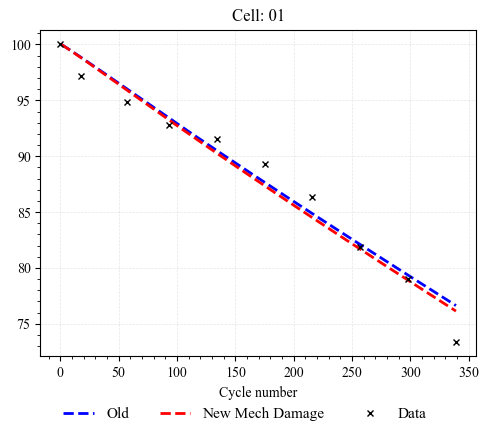

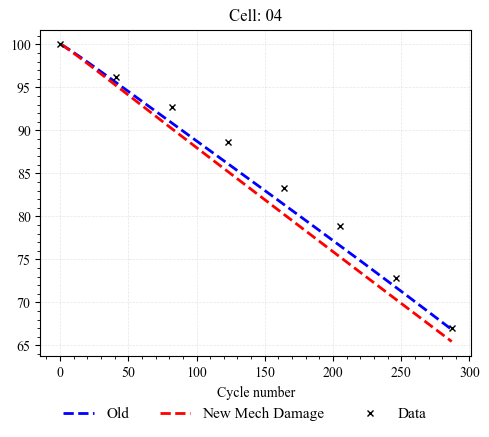

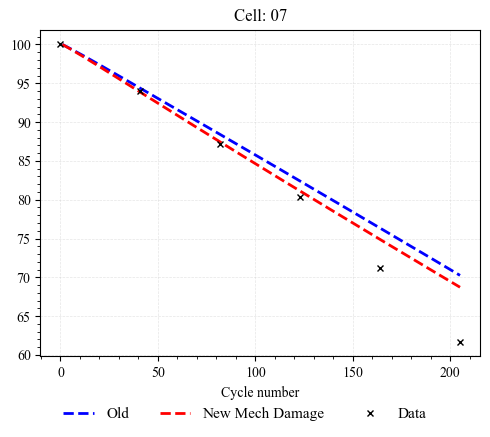

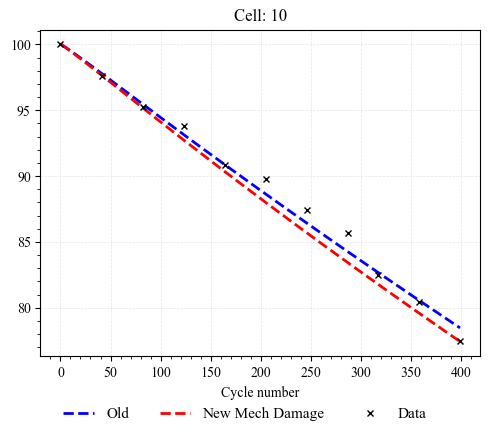

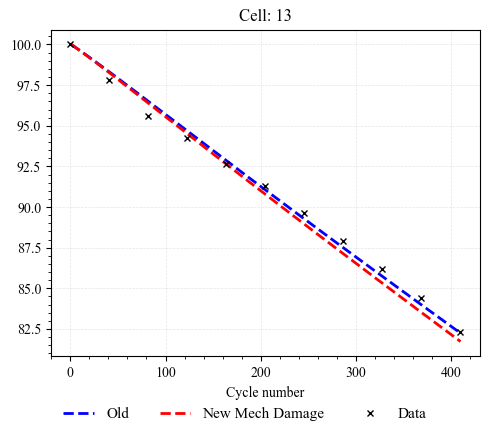

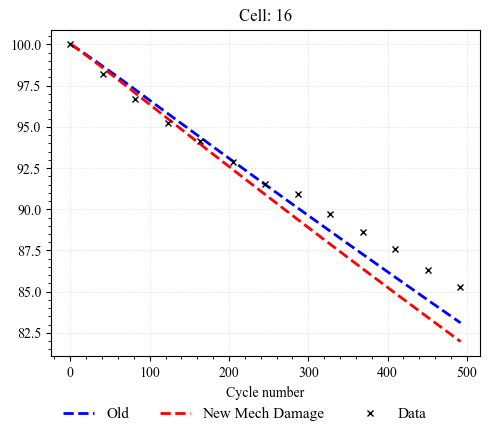

In [3]:
cells = [1,4,7,10,13,16]
# cells = [19]
for cell in cells:
    sno = 15
    sim_des = f'cond{sno}'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 16
    sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc2_cap(data1,data2,dfe,leg1="Old",leg2="New Mech Damage");
    plt.title("Cell: "+cell_no)
    fig.savefig(fig_DIR +'com_mech_damage_model_cell_'+cell_no+'_cap.png')

# eSOH

In [ ]:
cells = [1,4,7,10,13,16]
# cells = [19]
# cells = [3,6,9,12,15,18]
for cell in cells:
    sno = 13
    sim_des = f'cond{sno}'
    # sim_des = sim_des+'_io_1'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 14
    sim_des = f'cond{sno}'
    # sim_des = sim_des+'_io_2'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc2(data1,data2,dfe,leg1=r"Old Mech",leg2=r"Mech Mixed");
    fig.savefig(fig_DIR +'com_mech_damage_model_cell_'+cell_no+'_eSOH.png')

In [ ]:
cells = [1,4,7,10,13,16]
cells = [19]
# cells = [3,6,9,12,15,18]
for cell in cells:
    sno = 13
    sim_des = f'cond{sno}'
    # sim_des = sim_des+'_io_1'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 14
    sim_des = f'cond{sno}'
    # sim_des = sim_des+'_io_2'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc(data1,dfe);
    fig.savefig(fig_DIR +'aging_sim_cell_'+cell_no+'_eSOH.png')

# Plot Capacity Loss

In [ ]:
asda

RMSE: 1.4512710184353048
RMSE: 1.5781009580459793
RMSE: 4.192563010772077
RMSE: 0.733784939829675


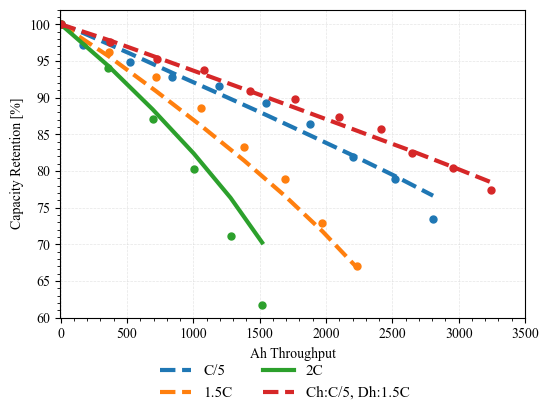

In [37]:
cells = [1,4,7,10]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    cap_data = dfe["Cap"]/dfe["Cap"][0]*100
    ax.plot(dfe["Ah_th"],cap_data,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    cap_sim = df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100
    if cell == 7:
        ax.plot(dfe["Ah_th"],cap_sim,color=colors[i],linewidth=3)
    else:    
        ax.plot(dfe["Ah_th"],cap_sim,'--',color=colors[i],linewidth=3)
    rmse = pybamm.rmse(cap_data,cap_sim)
    print(f"RMSE: {rmse}")
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
# ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_cap_1.png')
plt.savefig(fig_DIR +'cycling_aging_room_cap_1_'+sim_des+'.png')
plt.show()

RMSE: 1.4435814122420358
RMSE: 0.6821075308880116
RMSE: 1.1567858716388477
RMSE: 1.9046984862601282


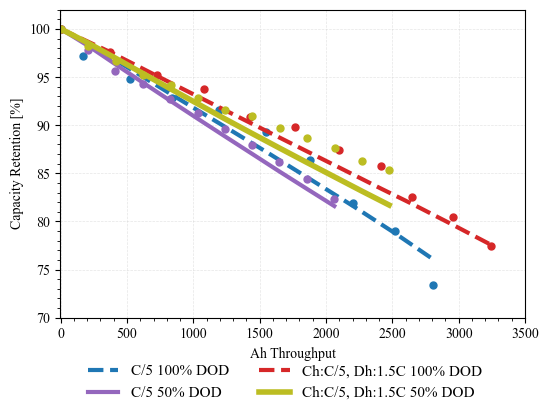

In [39]:
cells = [1,13,10,16]
sno = 18
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    cap_data = dfe["Cap"]/dfe["Cap"][0]*100
    cap_sim = df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100
    if cell == 13:
        ax.plot(dfe["Ah_th"],cap_sim,color=colors[i],linewidth=3)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],cap_sim,color=colors[i],linewidth=4)
    else:
        ax.plot(dfe["Ah_th"],cap_sim,'--',color=colors[i],linewidth=3)
    i+=1
    rmse = pybamm.rmse(cap_data,cap_sim)
    print(f"RMSE: {rmse}")
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
# ax.set_title(r'C/20 Capacity')
ax.set_ylim([70,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 100% DOD','C/5 50% DOD','Ch:C/5, Dh:1.5C 100% DOD','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_cap_2.png')
plt.savefig(fig_DIR +'cycling_aging_room_cap_2_'+sim_des+'.png')
plt.show()

In [ ]:
cells = [1,13,10,16]
sno = 16
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=4)
    else:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
# ax.set_title(r'C/20 Capacity')
ax.set_ylim([70,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Ch:C/5, Dh:1.5C','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_cap_2.png')
plt.savefig(fig_DIR +'cycling_aging_room_cap_2_'+sim_des+'.png')
plt.show()

In [ ]:
cells = [13,16,19]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:brown","tab:olive","magenta"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=4)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=2)
    else:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 50% DOD','Mixed 50% DOD', 'Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_cap_S2.png')
plt.show()

In [ ]:
cells = [3,6,9,12]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_cap_1.png')
plt.show()

In [ ]:
cells = [3,15,12,18]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=4)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=2)
    else:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_cap_2.png')
plt.show()

# Irreversible Expansion Plots

In [ ]:
b1 = 737.578
b2 = 1004.319
b3 = 0
b4 = 0
# b1 = 700
# b2 = 1400

In [21]:
b1 = 830.05
b2 = 0
b3 = 0
b4 = 14528.12

b1 = 829.75
b2 = 0
b3 = 0
b4 = 17187.93

In [18]:
# sno 15
b1 =544.61
b2 =11004.28
b3 =413.85
b4 =0.0

In [15]:
# sno 17
b1 = 479.83
b2 = 5779.74
b3 = 528.77
b4 = 0.0

17.51547628431342
22.776316361926746
54.25582236055286
12.901112188541118


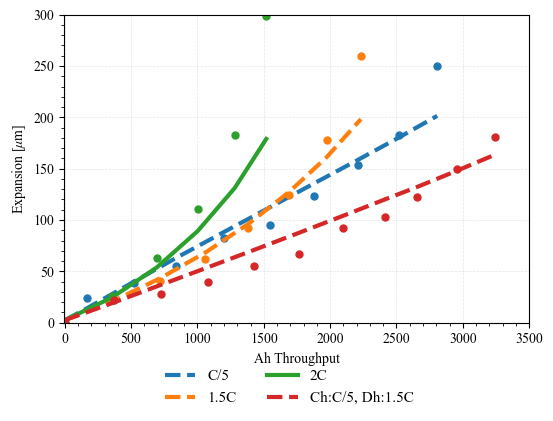

In [45]:
cells = [1,4,7,10]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    # del_sei = df["X-averaged SEI thickness [m]"]
    # del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    else:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],'--',color=colors[i],linewidth=3)
    print(pybamm.rmse(dfe["irrev_exp"],irrev_exp[Ns]))
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_expansion_1.png')
plt.savefig(fig_DIR +'cycling_aging_room_expansion_1_'+sim_des+'.png')
plt.show()

17.51547628431342
10.425676299707648
12.901112188541118
13.808680288826007


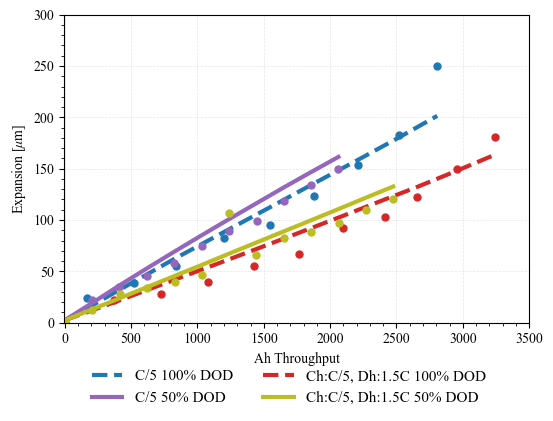

In [47]:
cells = [1,13,10,16]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    # del_sei = df["X-averaged SEI thickness [m]"]
    # del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    else:
        ax.plot(dfe["Ah_th"],irrev_exp[Ns],'--',color=colors[i],linewidth=3)
    print(pybamm.rmse(dfe["irrev_exp"],irrev_exp[Ns]))
    i+=1
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 100% DOD','C/5 50% DOD','Ch:C/5, Dh:1.5C 100% DOD','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_expansion_2.png')
plt.savefig(fig_DIR +'cycling_aging_room_expansion_2_'+sim_des+'.png')
plt.show()

In [ ]:
cells = [3,6,9]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,160])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_expansion_1.png')
plt.show()

In [ ]:
cells = [3,15,18]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_ylim([0,200])
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_expansion_2.png')
plt.show()

In [ ]:
cells = [1,3]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'C/5 Irreversible Expansion')
ax.set_ylim([0,250])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'C5_irrev_exp_comp.png')
plt.show()

In [ ]:
cells = [4,6]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'1.5C Irreversible Expansion')
ax.set_ylim([0,250])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'1p5C_irrev_exp_comp.png')
plt.show()

In [ ]:
cells = [7,9]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'2C Irreversible Expansion')
ax.set_ylim([0,250])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'2C_irrev_exp_comp.png')
plt.show()

# Resistance Plots

In [23]:
res_DIR

'../data/results_paper/'

RMSE: 10.217321452483283
RMSE: 3.448185787940073
RMSE: 7.835830819564511
RMSE: 9.823058697942917


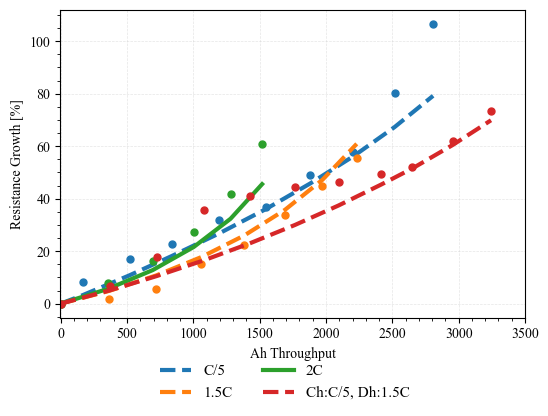

In [41]:
cells = [1,4,7,10]
sno = 15
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    # df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    df = pd.read_csv(res_DIR + "DC_resistance"+sim_des+"_cell_"+cell_no+".csv")
    
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    else:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,'--',color=colors[i],linewidth=3)
    rmse = pybamm.rmse((df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100)
    print(f"RMSE: {rmse}")
    i+=1
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
# ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_resistance_1.png')
plt.savefig(fig_DIR +'cycling_aging_room_resistance_1_'+sim_des+'.png')

RMSE: 8.871749075322702
RMSE: 4.829919187349016
RMSE: 8.975857647198758
RMSE: 6.702262504062152


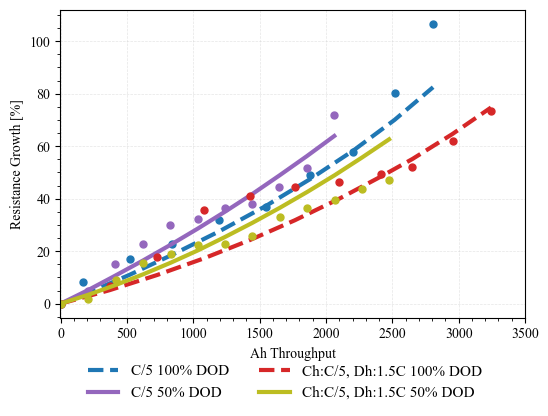

In [43]:
cells = [1,13,10,16]
sno = 18
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no = f'{cell:02d}'
    # df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    df = pd.read_csv(res_DIR + "DC_resistance"+sim_des+"_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    else:
        ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,'--',color=colors[i],linewidth=3)
    rmse = pybamm.rmse((df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100)
    print(f"RMSE: {rmse}")
    i+=1
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
# ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 100% DOD','C/5 50% DOD','Ch:C/5, Dh:1.5C 100% DOD','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.13], ncol=2, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_room_resistance_2.png')
plt.savefig(fig_DIR +'cycling_aging_room_resistance_2_'+sim_des+'.png')

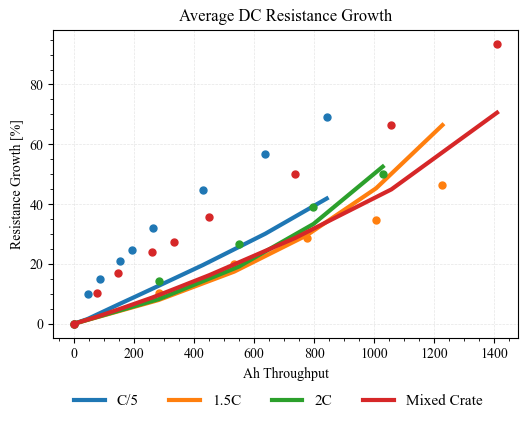

In [35]:
cells = [3,6,9,12]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_resistance_1.png')

In [ ]:
cells = [3,15,12,18]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_resistance_2.png')

In [ ]:
cells = [1,3]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'C/5 Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'C5_resistance_comp.png')

In [ ]:
cells = [4,6]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'1.5C Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'1p5C_resistance_comp.png')

In [ ]:
cells = [7,9]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'2C Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'2C_resistance_comp.png')

In [ ]:
cells = [10,12]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Mixed Crate Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'mixedC_resistance_comp.png')

# SEI Plots

In [ ]:
cells = [1,3]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],1e9*df["X-averaged SEI thickness [m]"][Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Thickness [nm]")
ax.set_title(r'SEI Thickness')
# ax.set_ylim([60,102])
# ax.set_xlim([-5,3500])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_hot_cap_1.png')
plt.show()

# Degradation Modes

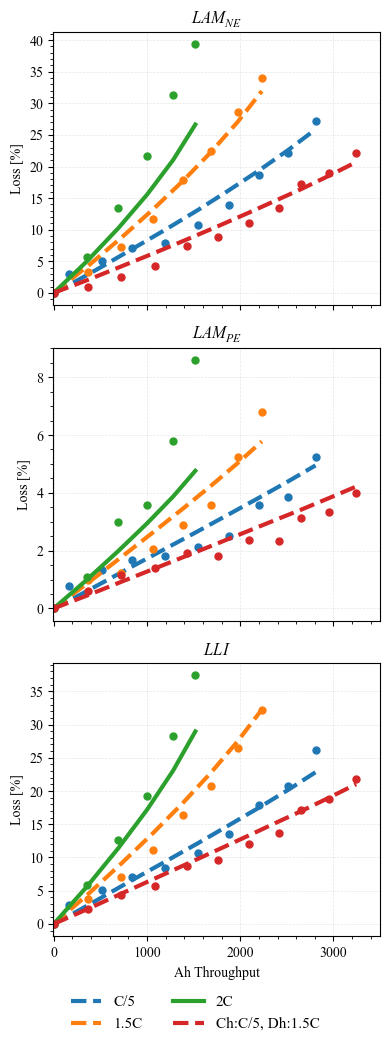

In [48]:
cells = [1,4,7,10]
sno = 15
sim_des = f'cond{sno}'
# fig, ax = plt.subplots(1,3,figsize=(10,4),sharex=True)
fig, ax = plt.subplots(3,1,figsize=(4,10),sharex=True)
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax1 = ax.flat[0]
    ax1.plot(dfe["Ah_th"],(dfe["C_n"][0]-dfe["C_n"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax2 = ax.flat[1]
    ax2.plot(dfe["Ah_th"],(dfe["C_p"][0]-dfe["C_p"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax3 = ax.flat[2]
    ax3.plot(dfe["Ah_th"],dfe["Loss of lithium inventory [%]"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 7:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],color=colors[i],linewidth=3)
    else:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],'--',color=colors[i],linewidth=3)
    i+=1
# ax1.set_xlabel('Ah Throughput')
# ax2.set_xlabel('Ah Throughput')
ax3.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Loss [%]")
ax2.set_ylabel(r"Loss [%]")
ax3.set_ylabel(r"Loss [%]")
ax1.set_title(r'$LAM_{NE}$')
ax2.set_title(r'$LAM_{PE}$')
ax3.set_title(r'$LLI$')
# ax.set_ylim([60,102])
ax1.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Ch:C/5, Dh:1.5C'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=2, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_deg_mode_1.png')
plt.show()

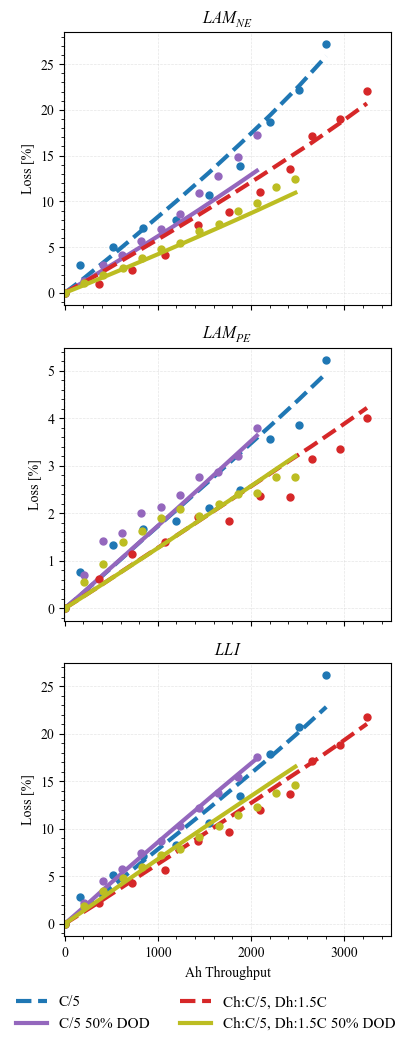

In [18]:
cells = [1,13,10,16]
# fig, ax = plt.subplots(1,3,figsize=(10,4),sharex=True)
fig, ax = plt.subplots(3,1,figsize=(4,10),sharex=True)
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax1 = ax.flat[0]
    ax1.plot(dfe["Ah_th"],(dfe["C_n"][0]-dfe["C_n"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax2 = ax.flat[1]
    ax2.plot(dfe["Ah_th"],(dfe["C_p"][0]-dfe["C_p"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    else:
        ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,'--',color=colors[i],linewidth=3)
    ax3 = ax.flat[2]
    ax3.plot(dfe["Ah_th"],dfe["Loss of lithium inventory [%]"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13 or cell == 16:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],color=colors[i],linewidth=3)
    else:
        ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],'--',color=colors[i],linewidth=3)
    i+=1
# ax1.set_xlabel('Ah Throughput')
# ax2.set_xlabel('Ah Throughput')
ax3.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Loss [%]")
ax2.set_ylabel(r"Loss [%]")
ax3.set_ylabel(r"Loss [%]")
ax1.set_title(r'$LAM_{NE}$')
ax2.set_title(r'$LAM_{PE}$')
ax3.set_title(r'$LLI$')
# ax.set_ylim([60,102])
ax1.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Ch:C/5, Dh:1.5C','Ch:C/5, Dh:1.5C 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=2, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_deg_mode_2.png')
plt.show()

# eSOH Plots

In [ ]:
def plotc2_cap(all_sumvars_dict1,all_sumvars_dict2,esoh_data,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    name = "Capacity [A.h]"
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b--")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"r--")
    ax.plot(esoh_data["N"],esoh_data[name],"kx")
    ax.set_title(split_long_string(name))
    ax.set_xlabel("Cycle number")
    fig.legend([leg1, leg2 , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=3, fontsize=11)
    fig.tight_layout()
    return fig

In [13]:
sno = 15
sim_des = f'cond{sno}'
cell = 1
cell_no,dfe1,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data1 = pickle.load(handle)
cell = 4
cell_no,dfe2,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
cell = 10
cell_no,dfe3,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data3 = pickle.load(handle)
# fig.savefig(fig_DIR +'com_exch_current_cell_'+cell_no+'_eSOH.png')

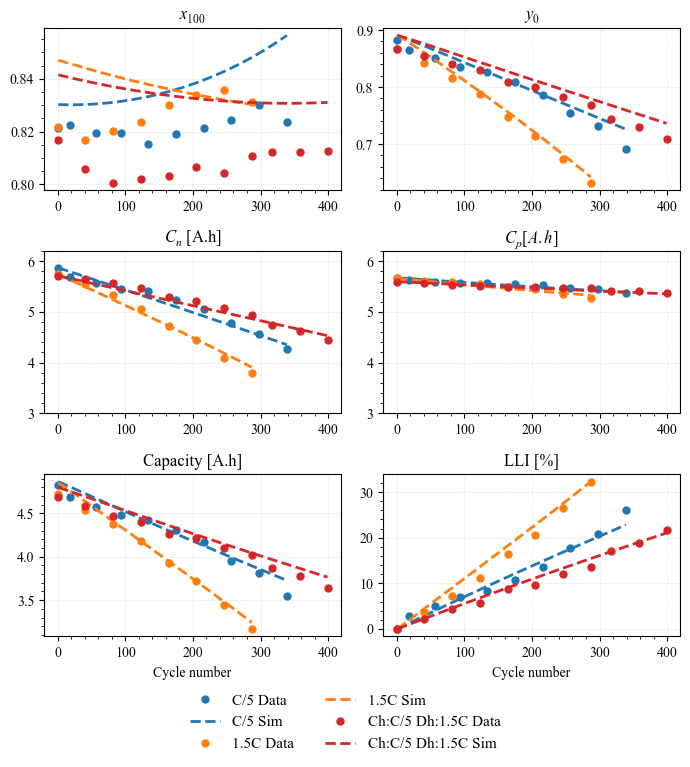

In [15]:
esoh_data = dfe1
esoh_data_2 = dfe2
esoh_data_3 = dfe3
all_sumvars_dict1 = data1
all_sumvars_dict2 = data2
all_sumvars_dict3 = data3
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
titles = [r"$x_{100}$",r"$y_0$",r"$C_n$ [A.h]",r"$C_p [A.h]$", "Capacity [A.h]", "LLI [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,7))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(esoh_data["N"],esoh_data[name],"o",color="tab:blue")
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"--",color="tab:blue")
    ax.plot(esoh_data_2["N"],esoh_data_2[name],"o",color="tab:orange")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"--",color="tab:orange")
    ax.plot(esoh_data_3["N"],esoh_data_3[name],"o",color="tab:red")
    ax.plot(all_sumvars_dict3["Cycle number"],all_sumvars_dict3[name],"--",color="tab:red")
    ax.set_title(titles[k])
    if k ==2 or k==3:
        ax.set_ylim([3,6.2])
    if k>3:
        ax.set_xlabel("Cycle number")
fig.legend(["C/5 Data","C/5 Sim","1.5C Data","1.5C Sim","Ch:C/5 Dh:1.5C Data","Ch:C/5 Dh:1.5C Sim" ], 
        loc="lower center",bbox_to_anchor=[0.5,-0.1], ncol=2, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR +'cycling_aging_1_4_10.png')

In [ ]:
sim_des = f'cal'
cell = 22
cell_no,dfe1,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data1 = pickle.load(handle)
cell = 24
cell_no,dfe2,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
# fig.savefig(fig_DIR +'com_exch_current_cell_'+cell_no+'_eSOH.png')

In [ ]:
esoh_data = dfe1
esoh_data_2 = dfe2
all_sumvars_dict1 = data1
all_sumvars_dict2 = data2
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
titles = [r"$x_{100}$",r"$y_0$",r"$C_n$ [A.h]",r"$C_p [A.h]$", "Capacity [A.h]", "LLI [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,7))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(esoh_data["N"],esoh_data[name],"ro")
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r--")
    ax.plot(esoh_data_2["N"],esoh_data_2[name],"bo")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"b--")
    ax.set_title(titles[k])
    if k ==2 or k==3:
        ax.set_ylim([3,6.2])
    if k>3:
        ax.set_xlabel("Days")
fig.legend(["Hot Data","Hot Sim","Cold Data","Cold Sim" ], 
        loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=4, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR +'calendar_aging_1.png')

## eSOH all cells

In [ ]:
sno = 15
sim_des = f'cond{sno}'
cells = [1,4,10]
for cell in cells:
    cell_no,dfe1,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    esoh_data = dfe1
    all_sumvars_dict1 = data1
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    titles = [r"$x_{100}$",r"$y_0$",r"$C_n$ [A.h]",r"$C_p [A.h]$", "Capacity [A.h]", "LLI [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(esoh_data["N"],esoh_data[name],"ko")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r--")
        ax.set_title(titles[k])
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Data","Sim"], 
            loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=4, fontsize=11)
    fig.tight_layout()
    fig.savefig(fig_DIR +'aging_sim_cell_'+cell_no+'_eSOH.png')

# Cycling Voltage

In [ ]:
asdasdasd

In [5]:
def load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    # print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    E = E_c1[:idx_I[0]]-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [6]:
def get_rmse(t_d,V_d,E_d,t,Vt,Exp):
    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q,Exp,extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    return rmse_V,rmse_E

In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(3,3,figsize=(10,9))
for cyc_no in [0,int((len(N)+1)/2)-1,len(N)-1]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
    ax1 = ax.flat[i+3]
    ax1.plot(t_d/3600,V_d,'k',linewidth=2)
    ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
    ax1.set_xlabel('Time [h]')
    ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    ax2 = ax.flat[i]
    ax2.plot(t_d/3600,I_d,'k',linewidth=2)
    ax2.plot(df['t']/3600,-df["I"],'r--',linewidth=2)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax3 = ax.flat[i+6]
    ax3.plot(t_d/3600,E_d,'k',linewidth=2)
    ax3.plot(df['t']/3600,df["Exp"],'r--',linewidth=2)
    ax3.set_xlabel('Time [h]')
    ax3.set_ylim([0,110])
    ax3.set_ylabel('$\Delta t$ [$\mu$m]')
    ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax20 = ax.flat[3]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[6]
ax30.text(-0.2,1.1,f'c) Reversible Expansion',transform=ax30.transAxes,fontsize=16)
ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_error_cell_'+cell_no+'_ch.png')

In [ ]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2)-1,len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
    ax2 = ax.flat[i]
    ax2.plot(t_d/3600,I_d,'k',linewidth=2)
    ax2.plot(df['t']/3600,-df["I"],'r--',linewidth=2)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_xlim(right=1)
    ax2.set_ylabel('$I$ [A]')
    ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'current_cell_'+cell_no+'_ch.png')

In [ ]:
print(0.563/0.892)
print(0.377/0.778)
print(0.403/0.755)
print(0.292/0.692)

In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(3,1,figsize=(6,9))
Ns = np.insert(N[1:]-1,0,0)

with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
irrev_exp = 1e6*(b1*del_sei + b2*del_li)
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
    ax1 = ax.flat[1]
    ax1.plot(t_d/3600,V_d,'k',linewidth=2)
    ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
    ax1.set_xlabel('Time [h]')
    # ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    ax2 = ax.flat[0]
    ax2.plot(t_d/3600,I_d,'k',linewidth=2)
    ax2.plot(df['t']/3600,-df["I"],'r--',linewidth=2)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    # ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax3 = ax.flat[2]
    ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
    ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r--',linewidth=2)
    ax3.set_xlabel('Time [h]')
    # ax3.set_ylim([0,110])
    ax3.set_ylabel('$\Delta t$ [$\mu$m]')
    # ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax20 = ax.flat[1]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[2]
ax30.text(-0.2,1.1,f'c) Total Expansion',transform=ax30.transAxes,fontsize=16)
ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_texp_error_cell_'+cell_no+'_ch.png')

In [ ]:
sno = 7
sim_des = f'cond{sno}'
cell = 7
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(3,1,figsize=(6,9))
Ns = np.insert(N[1:]-1,0,0)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
for cyc_no in [0,int((len(N)+1)/2)-1,len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
    ax1 = ax.flat[1]
    ax1.plot(t_d/3600,V_d,'k',linewidth=2)
    ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
    ax1.set_xlabel('Time [h]')
    # ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    ax2 = ax.flat[0]
    ax2.plot(t_d/3600,I_d,'k',linewidth=2)
    ax2.plot(df['t']/3600,-df["I"],'r--',linewidth=2)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    # ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax3 = ax.flat[2]
    ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
    ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r--',linewidth=2)
    ax3.set_xlabel('Time [h]')
    # ax3.set_ylim([0,110])
    ax3.set_ylabel('$\Delta t$ [$\mu$m]')
    # ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax20 = ax.flat[1]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[2]
ax30.text(-0.2,1.1,f'c) Total Expansion',transform=ax30.transAxes,fontsize=16)
ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_texp_error_cell_'+cell_no+'_ch.png')

In [ ]:

titles = ["BOL","MOL","EOL"]
sno = 7
sim_des = f'cond{sno}'
i = 0
fig, ax = plt.subplots(3,3,figsize=(12,9))
cells = [1,4,7]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    cycles = [0,int((len(N)+1)/2),len(N)-2]
    if cell == 1:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    if cell == 7:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    for cyc_no in cycles:
        print(cyc_no)
        t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
        df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
        rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
        ax1 = ax.flat[i+3]
        ax1.plot(t_d/3600,V_d,'k',linewidth=2)
        ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
        ax1.set_xlabel('Time [h]')
        # ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
        ax1.set_ylabel('$V_t$ [Ah]')
        ax2 = ax.flat[i]
        ax2.plot(t_d/3600,I_d,'k',linewidth=2)
        ax2.plot(df['t']/3600,-df["I"],'r--',linewidth=2)
        ax2.set_xlabel('Time [h]')
        ax2.set_ylim(bottom=0)
        ax2.set_ylabel('$I$ [A]')
        # ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
        ax3 = ax.flat[i+6]
        ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
        ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r--',linewidth=2)
        ax3.set_xlabel('Time [h]')
        ax3.set_ylim([0,275])
        ax3.set_ylabel('$\Delta t$ [$\mu$m]')
        # ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax10.set_title("C/5 Cycling")
ax11 = ax.flat[1]
ax11.set_title("1.5C Cycling")
ax12 = ax.flat[2]
ax12.set_title("2C Cycling")
ax20 = ax.flat[3]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[6]
ax30.text(-0.2,1.1,f'c) Total Expansion',transform=ax30.transAxes,fontsize=16)
ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_error_cell_all_ch.png')

# Delta SEI, Delta Li

In [ ]:
cells = [1,4,7,10]
sno = 7
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    # ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],del_sei[Ns]*1e9,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Thickness [nm]")
ax.set_title(r'SEI Thickness $\delta_\mathrm{SEI}$')
ax.set_ylim([0,250])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_delta_sei.png')
plt.show()

In [ ]:
cells = [1,4,7,10]
sno = 7
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    # ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],del_li[Ns]*1e9,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Thickness [nm]")
ax.set_title(r'Plated Li Thickness $\delta_\mathrm{Li}$')
ax.set_ylim([0,250])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_delta_li.png')
plt.show()

# Cycling Voltage + Total Expansion Final

In [4]:
b1=544.61
b2=11004.28
b3=413.85
b4=0.0

0
4
8
0
4
6
0
2
4


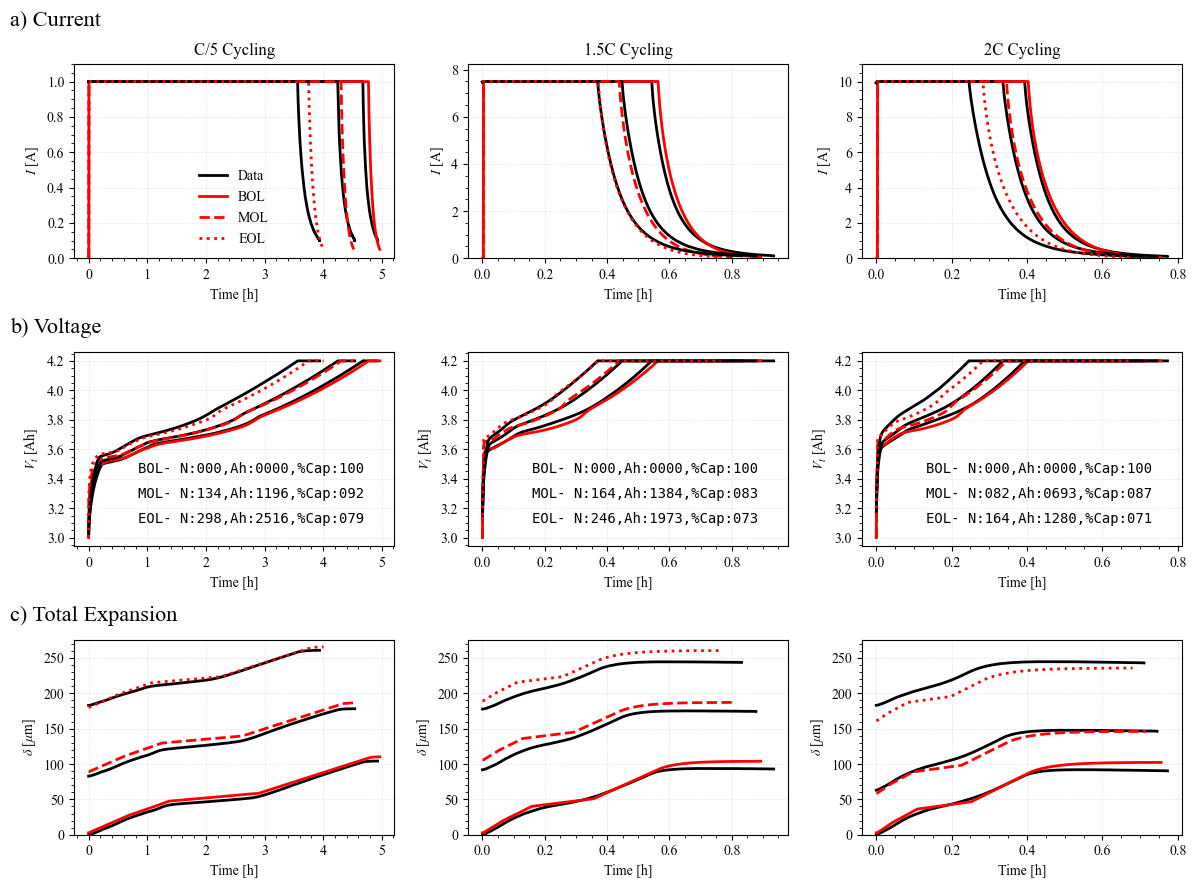

In [8]:
titles = ["BOL","MOL","EOL"]
linestyles = ["solid","dashed","dotted"]
sno = 15
sim_des = f'cond{sno}'
i = 0
fig, ax = plt.subplots(3,3,figsize=(12,9))
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
cycles = [0,int((len(N)+1)/2),len(N)-2]
if cell == 1:
    cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
cyc_no = cycles[0]
ax2 = ax.flat[0]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2)
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[0])
ax2.set_xlabel('Time [h]')
ax2.set_ylim(bottom=0)
ax2.set_ylabel('$I$ [A]')
cyc_no = cycles[1]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2,label="_nolegend_")
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[1])
cyc_no = cycles[2]
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
ax2.plot(t_d/3600,I_d,'k',linewidth=2,label="_nolegend_")
ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[2])
ax2.legend(["Data","BOL","MOL","EOL"])
cells = [1,4,7]
for cell in cells:
    j=0
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    # del_sei = df["X-averaged SEI thickness [m]"]
    # del_li = df["X-averaged lithium plating thickness [m]"]
    # irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
    es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
    irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
    cycles = [0,int((len(N)+1)/2),len(N)-2]
    if cell == 1:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    if cell == 7:
        cycles = [0,int((len(N)+1)/2)-1,len(N)-2]
    for cyc_no in cycles:
        print(cyc_no)
        t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
        df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
        rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
        ax1 = ax.flat[i+3]
        ax1.plot(t_d/3600,V_d,'k',linewidth=2)
        ax1.plot(df['t']/3600,df["Vt"],'r',linewidth=2,linestyle=linestyles[j])
        ax1.set_xlabel('Time [h]')
        ax1.text(0.2,0.38-0.13*j,'{}- N:{:03.0f},Ah:{:04.0f},%Cap:{:03.0f}'.format(titles[j],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100),transform=ax1.transAxes,family='monospace',fontsize='10')
        ax1.set_ylabel('$V_t$ [Ah]')
        if cell == 1:
            pass
        else:
            ax2 = ax.flat[i]
            ax2.plot(t_d/3600,I_d,'k',linewidth=2)
            ax2.plot(df['t']/3600,-df["I"],'r',linewidth=2,linestyle=linestyles[j])
            ax2.set_xlabel('Time [h]')
            ax2.set_ylim(bottom=0)
            ax2.set_ylabel('$I$ [A]')
        # ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
        ax3 = ax.flat[i+6]
        ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
        ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r',linewidth=2,linestyle=linestyles[j])
        ax3.set_xlabel('Time [h]')
        ax3.set_ylim([0,275])
        ax3.set_ylabel('$\delta$ [$\mu$m]')
        # ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
        j+=1
    i+=1
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax10.set_title("C/5 Cycling")
ax11 = ax.flat[1]
ax11.set_title("1.5C Cycling")
ax12 = ax.flat[2]
ax12.set_title("2C Cycling")
ax20 = ax.flat[3]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[6]
ax30.text(-0.2,1.1,f'c) Total Expansion',transform=ax30.transAxes,fontsize=16)
# ax3.legend(["Data","Sim"])
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_error_cell_all_ch.png')

In [9]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-2]-2
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1
    V = V_c1
    I = I_c1
    E = E_c1-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


42
437


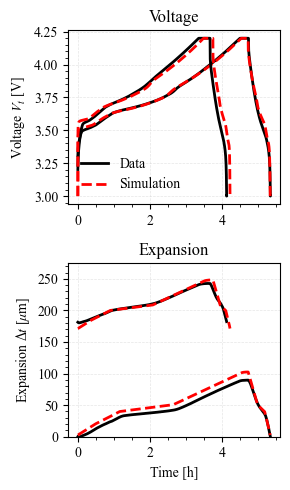

In [10]:
titles = ["BOL","MOL","EOL"]
linestyles = ["solid","dashed","dotted"]
sno = 15
sim_des = f'cond{sno}'
i = 0
cell = 10

fig, ax = plt.subplots(2,1,figsize=(3,5))
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
# del_sei = df["X-averaged SEI thickness [m]"]
# del_li = df["X-averaged lithium plating thickness [m]"]
# irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
for cyc_no in [0,len(N)-1]:
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[0]
    ax1.plot(t_d/3600,V_d,'k',linewidth=2)
    ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
    # ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Voltage $V_t$ [V]')
    ax1.set_title('Voltage')
    # ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax1.legend(["Data",'Simulation'])
    ax3 = ax.flat[1]
    ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
    ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r--',linewidth=2)
    ax3.set_xlabel('Time [h]')
    ax3.set_ylim([0,275])
    ax3.set_ylabel('Expansion $\Delta t$ [$\mu$m]')
    ax3.set_title('Expansion')
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_cell_10.png')

437


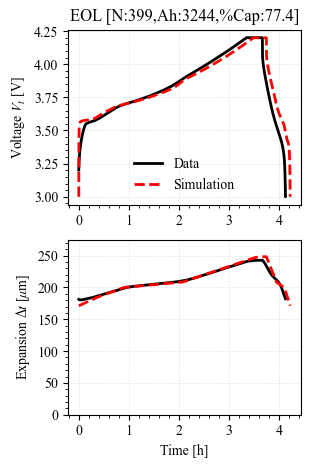

In [11]:
titles = ["BOL","MOL","EOL"]
linestyles = ["solid","dashed","dotted"]
sno = 15
sim_des = f'cond{sno}'
i = 2
cell = 10
cyc_no = len(N)-1 
fig, ax = plt.subplots(2,1,figsize=(3,5))
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
# del_sei = df["X-averaged SEI thickness [m]"]
# del_li = df["X-averaged lithium plating thickness [m]"]
# irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
t_d,V_d,I_d,Q_d,E_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
ax1 = ax.flat[0]
ax1.plot(t_d/3600,V_d,'k',linewidth=2)
ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
# ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Voltage $V_t$ [V]')
ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
ax1.legend(["Data",'Simulation'])
ax3 = ax.flat[1]
ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r--',linewidth=2)
ax3.set_xlabel('Time [h]')
ax3.set_ylim([0,275])
ax3.set_ylabel('Expansion $\Delta t$ [$\mu$m]')
plt.savefig(fig_DIR +'volt_exp_cell_10_400.png')